# Package Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(font_scale=1.2, context="paper", style="ticks")
sns.set_palette("viridis")

import mysql.connector as mariadb
from astropy.time import Time

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("..")

In [2]:
os.environ.get("CONDA_PREFIX")

'/epyc/opt/anaconda'

In [3]:
os.nice(1)

1

In [4]:
import thor

## Data Processing

In [71]:
# Connect to database
con = mariadb.connect(user='ztf', database='ztf')

In [6]:
# https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html

In [7]:
# Read alerts for solar system objects from after the photometry fix 
sso_alert_fix_date1 = Time('2018-05-16T23:30:00', format='isot', scale='utc') # first attribution fix
sso_alert_fix_date2 = Time('2018-06-08T23:30:00', format='isot', scale='utc') # second attribution fix
sso_alert_phot_fix_date = Time('2018-06-18T23:30:00', format='isot', scale='utc') # photometry fix date

jd_good = sso_alert_phot_fix_date.jd
#ssdistnr >= 0 
df = pd.read_sql_query('select * from alerts where jd > {} and ssdistnr >= 0'.format(jd_good), con)
print(len(df))

869616


In [8]:
df.sort_values(by=["jd"], inplace=True)
df.reset_index(inplace=True)

In [9]:
df.head(10)

,index,objectId,jd,fid,pid,diffmaglim,programid,candid,isdiffpos,tblid,...,clrcounc,zpclrcov,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime
0,0,ZTF18abcdwzp,2.458289e+06,3,534178763215,19.8391,2,534178763215015012,t,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,ZTF18abcdxgz,2.458289e+06,3,534186883815,19.6875,2,534186883815015006,t,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,ZTF18abcdxlq,2.458289e+06,1,534194142015,20.4920,2,534194142015015009,t,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,344,ZTF18abcdxlx,2.458289e+06,1,534194655515,20.5510,1,534194655515015006,t,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,336,ZTF18abcdxjw,2.458289e+06,1,534195114715,20.4822,1,534195114715015006,t,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,337,ZTF18abcdxky,2.458289e+06,1,534195110615,20.3403,1,534195110615015008,t,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,338,ZTF18abcdxkx,2.458289e+06,1,534195112515,20.4844,1,534195112515015009,t,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,339,ZTF18abcdxlb,2.458289e+06,1,534195116015,20.3943,1,534195116015015011,t,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,340,ZTF18abcdxlw,2.458289e+06,1,534195110315,20.3434,1,534195110315015005,t,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,341,ZTF18abcdxmd,2.458289e+06,1,534195112315,20.4401,1,534195112315015000,t,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
columnMapping = {        
        
        # Observation ID
        "obs_id" : "obs_id",
        
        # Exposure time
        "exp_mjd" : "exp_mjd",
        
        # Visit ID
        "visit_id" : "visit_id",
        
        # Field ID
        "field_id" : "field",
        
        # Field RA in degrees
        "field_RA_deg" : "fieldRA_deg",
        
        # Field Dec in degrees
        "field_Dec_deg" : "fieldDec_deg",
        
        # Night number
        "night": "nid",
        
        # RA in degrees
        "RA_deg" : "ra",
        
        # Dec in degrees
        "Dec_deg" : "decl",
        
        # Observer's x coordinate in AU
        "obs_x_au" : "HEclObsy_X_au",
        
        # Observer's y coordinate in AU
        "obs_y_au" : "HEclObsy_Y_au",
        
        # Observer's z coordinate in AU
        "obs_z_au" : "HEclObsy_Z_au",
        
        # Magnitude (UNUSED)
        "mag" : "magpsf",
        
        ### Truth Parameters
        
        # Object name
        "name" : "designation",
        
        # Observer-object distance in AU
        "Delta_au" : "Delta_au",
        
        # Sun-object distance in AU (heliocentric distance)
        "r_au" : "r_au",
        
        # Object's x coordinate in AU
        "obj_x_au" : "HEclObj_X_au",
        
        # Object's y coordinate in AU
        "obj_y_au" : "HEclObj_Y_au",
        
        # Object's z coordinate in AU
        "obj_z_au" : "HEclObj_Z_au",
        
        # Object's x velocity in AU per day
        "obj_dx/dt_au_p_day" : "HEclObj_dX/dt_au_p_day",
        
        # Object's y velocity in AU per day
        "obj_dy/dt_au_p_day" : "HEclObj_dY/dt_au_p_day",
        
        # Object's z velocity in AU per day
        "obj_dz/dt_au_p_day" : "HEclObj_dZ/dt_au_p_day",
        
        # Semi-major axis
        "a_au" : "a_au",
        
        # Inclination
        "i_deg" : "i_deg",
        
        # Eccentricity
        "e" : "e",
    }

def prepareZTFAlertsForTHOR(alerts):
    # Sort by field and exposure time
    alerts.sort_values(by=["field", "jd"], inplace=True)
    
    # Add exposure time in MJD column
    times = Time(alerts["jd"], format="jd", scale="utc")
    times = times.mjd
    alerts["exp_mjd"] = times
    
    # Only keep columns we want
    alerts = alerts[["ra", "decl", "field", "nid", "jd", "exp_mjd", "magpsf", "sigmapsf", "fid", "ssnamenr"]]
    
    # Read footprint and get field center locations
    footprint = pd.read_csv("/epyc/projects/thor/ztf_information/field_grid/ZTF_Fields.txt",
                        delim_whitespace=True, 
                        skiprows=1,
                        names=["field", "fieldRA_deg", "fieldDec_deg", "Ebv", "Gal Long", "Gal Lat", "Ecl Long", "Ecl Lat" ,"Entry"])
    footprint = footprint[["field", "fieldRA_deg", "fieldDec_deg"]]
    

    survey = pd.DataFrame({"exp_mjd": alerts["exp_mjd"].unique(), "visit_id" : np.arange(1, len(alerts["exp_mjd"].unique()) + 1)})
    eph = thor.propagateTestParticle([1, 1, 0, 0.0002, 0.0002, 0.000], 59580, survey["exp_mjd"].values, observatoryCode="I41")
    survey = survey.merge(eph[["mjd", 'HEclObsy_X_au', 'HEclObsy_Y_au', 'HEclObsy_Z_au']], left_on="exp_mjd", right_on="mjd")
    
    observations = alerts.merge(footprint, left_on="field", right_on="field")
    observations = observations.merge(survey, on="exp_mjd")

    observations["obs_id"] = np.arange(1, len(observations) + 1)
    
    return observations

In [11]:
observations = prepareZTFAlertsForTHOR(df)
del df

In [12]:
observations.to_csv("../analysis/ztf/known_object_observations.txt", sep=" ", index=False)

In [13]:
observations = pd.read_csv("../analysis/ztf/known_object_observations.txt", sep=" ", index_col=False)

In [14]:
observations.head(10)

,ra,decl,field,nid,jd,exp_mjd,magpsf,sigmapsf,fid,ssnamenr,fieldRA_deg,fieldDec_deg,visit_id,mjd,HEclObsy_X_au,HEclObsy_Y_au,HEclObsy_Z_au,obs_id
0,1.823979,-26.530899,245,606,2.458361e+06,58360.399954,17.1856,0.050869,1,277529,1.16039,-24.25,1,58360.399954,0.927519,-0.399013,0.000036,1
1,3.424106,-24.019268,245,606,2.458361e+06,58360.399954,18.4710,0.132737,1,186910,1.16039,-24.25,1,58360.399954,0.927519,-0.399013,0.000036,2
2,359.714370,-26.833669,245,606,2.458361e+06,58360.399954,19.0730,0.178199,1,110784,1.16039,-24.25,1,58360.399954,0.927519,-0.399013,0.000036,3
3,0.686068,-27.268204,245,606,2.458361e+06,58360.399954,18.6833,0.213605,1,54291,1.16039,-24.25,1,58360.399954,0.927519,-0.399013,0.000036,4
4,3.047707,-24.621212,245,606,2.458361e+06,58360.399954,19.1278,0.212181,1,215529,1.16039,-24.25,1,58360.399954,0.927519,-0.399013,0.000036,5
5,2.269394,-24.705108,245,609,2.458364e+06,58363.334387,18.7573,0.133431,1,224663,1.16039,-24.25,2,58363.334387,0.945505,-0.352378,0.000039,6
6,359.865286,-26.278350,245,609,2.458364e+06,58363.334387,19.4659,0.201638,1,272471,1.16039,-24.25,2,58363.334387,0.945505,-0.352378,0.000039,7
7,2.551338,-24.995790,245,609,2.458364e+06,58363.334387,19.3703,0.172599,1,215529,1.16039,-24.25,2,58363.334387,0.945505,-0.352378,0.000039,8
8,0.115389,-24.877066,245,609,2.458364e+06,58363.334387,19.0539,0.105614,1,161963,1.16039,-24.25,2,58363.334387,0.945505,-0.352378,0.000039,9
9,2.085536,-27.214909,245,609,2.458364e+06,58363.334387,17.1913,0.055068,1,277529,1.16039,-24.25,2,58363.334387,0.945505,-0.352378,0.000039,10


In [15]:
# Unique solar system objects in ZTF alerts
observations["ssnamenr"].nunique()

117121

In [16]:
# Multiple formats for ssnamenr field in alerts db
np.random.choice(observations[observations["ssnamenr"].str.isnumeric()]["ssnamenr"].values, 20)

array(['39999', '64797', '122855', '51841', '142627', '41340', '54383',
       '55926', '417650', '111142', '110231', '125175', '89207', '34739',
       '428695', '333095', '13306', '101515', '28348', '228891'],
      dtype=object)

In [17]:
np.random.choice(observations[~observations["ssnamenr"].str.isnumeric()]["ssnamenr"].values, 20)

array(['2011VR12', '2016EK155', '2012HA27', '2002PM51', '2018QF05',
       '2015BQ268', '2014QP01', '2008YE62', '2010EJ168', '2012UO134',
       '2014YF16', '2014SH210', '2018SB06', '2012OD01', '2011UN265',
       '2013WG110', '2014UJ34', '2016CW18', '2015DQ215', '2013RH30'],
      dtype=object)

In [18]:
mpcorb = thor.readMPCORBFile("../analysis/ztf/MPCORB_20181106.DAT")
# Drop two NaN rows... (population split)
mpcorb.drop(index=mpcorb[mpcorb["designation"].isna()].index, inplace=True)

In [19]:
np.random.choice(mpcorb[mpcorb["designation"].str.isnumeric()]["designation"].values, 20)

array(['00966', '10358', '14522', '98982', '78968', '38213', '20022',
       '44054', '61596', '36415', '47881', '34746', '63453', '83860',
       '85985', '16320', '61555', '37393', '77461', '27623'], dtype=object)

In [20]:
np.random.choice(mpcorb[~mpcorb["designation"].str.isnumeric()]["designation"].values, 20)

array(['K16E17U', 'j9452', 'c0438', 'g8546', 'K05T69K', 'X6479',
       'K09D28M', 'K07W03H', 'K14P20S', 'I8395', 'B8883', 'D9768',
       'q2932', 'd4460', 'e2941', 'K12O01A', 'N4521', 'B0933', 'e6385',
       'P0848'], dtype=object)

In [21]:
mpcorb[mpcorb["readableDesignation"].str.isnumeric()]["readableDesignation"].values

array([], dtype=object)

In [22]:
np.random.choice(mpcorb[~mpcorb["readableDesignation"].str.isnumeric()]["readableDesignation"].values, 20)

array(['(21229) Susil', '2016 QC52', '(490661) 2010 GN132', '2011 YO57',
       '(418998) 2009 OY10', '(121534) 1999 UJ41', '2015 HH170',
       '2006 VM127', '(354427) 2003 WN122', '(160437) 2005 SS139',
       '(318205) 2004 RT168', '2016 DQ32', '(302167) 2001 TS14',
       '(151419) 2002 EA150', '(335184) 2005 BM49', '2009 SO370',
       '(162867) 2001 EA19', '2006 TW102', '(490543) 2009 VD55',
       '(91472) 1999 RY91'], dtype=object)

In [23]:
# Do pandas magic... 
split_readable_designation = mpcorb["readableDesignation"].str.split(" ", expand=True)
mpcorb.loc[split_readable_designation[0].str.contains("\("), "splitname"] = split_readable_designation[0]
mpcorb.loc[~mpcorb["splitname"].isna(), "splitname"] = mpcorb[~mpcorb["splitname"].isna()]["splitname"].map(lambda x: x.lstrip('\(').rstrip('\)'))
mpcorb.loc[(~mpcorb["readableDesignation"].str.contains("\(")) 
           & (mpcorb["readableDesignation"].str.contains(" ")), "splitname"] = mpcorb[(~mpcorb["readableDesignation"].str.contains("\(")) 
                                                                                      & (mpcorb["readableDesignation"].str.contains(" "))]["readableDesignation"].str.replace(" ", "")

In [24]:
observations = observations.merge(mpcorb[["designation", "splitname"]], left_on="ssnamenr", right_on="splitname", how='left')

In [25]:
observations["ssnamenr"].nunique()

117121

In [26]:
observations["designation"].nunique()

115694

In [27]:
observations.head()

,ra,decl,field,nid,jd,exp_mjd,magpsf,sigmapsf,fid,ssnamenr,fieldRA_deg,fieldDec_deg,visit_id,mjd,HEclObsy_X_au,HEclObsy_Y_au,HEclObsy_Z_au,obs_id,designation,splitname
0,1.823979,-26.530899,245,606,2.458361e+06,58360.399954,17.1856,0.050869,1,277529,1.16039,-24.25,1,58360.399954,0.927519,-0.399013,0.000036,1,R7529,277529
1,3.424106,-24.019268,245,606,2.458361e+06,58360.399954,18.4710,0.132737,1,186910,1.16039,-24.25,1,58360.399954,0.927519,-0.399013,0.000036,2,I6910,186910
2,359.714370,-26.833669,245,606,2.458361e+06,58360.399954,19.0730,0.178199,1,110784,1.16039,-24.25,1,58360.399954,0.927519,-0.399013,0.000036,3,B0784,110784
3,0.686068,-27.268204,245,606,2.458361e+06,58360.399954,18.6833,0.213605,1,54291,1.16039,-24.25,1,58360.399954,0.927519,-0.399013,0.000036,4,54291,54291
4,3.047707,-24.621212,245,606,2.458361e+06,58360.399954,19.1278,0.212181,1,215529,1.16039,-24.25,1,58360.399954,0.927519,-0.399013,0.000036,5,L5529,215529


In [28]:
observations.to_csv("../analysis/ztf/known_object_observations.txt", sep=" ", index=False)

In [29]:
observations = pd.read_csv("../analysis/ztf/known_object_observations.txt", sep=" ", index_col=False)

In [40]:
! oorb --task=mpcorb --mpcorb=../analysis/ztf/MPCORB_20181106.DAT --orb-out=../analysis/ztf/MPCORB_20181106.orb --conf=../analysis/ztf/oorb.conf

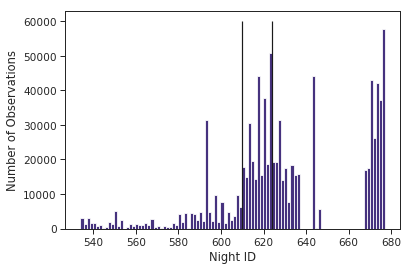

In [31]:
fig, ax = plt.subplots(1, 1) 
hist = ax.hist(observations["nid"].values, bins=100)
ax.set_xlabel("Night ID")
ax.set_ylabel("Number of Observations")
ax.vlines([610, 624], 0, 60000)

In [32]:
observations = observations[(observations["nid"] >= 610) & (observations["nid"] <= 624)]

In [33]:
observations.to_csv("../analysis/ztf/known_object_observations_nid_610_624.txt", sep=" ", index=False)

In [34]:
observations = pd.read_csv("../analysis/ztf/known_object_observations_nid_610_624.txt", sep=" ", index_col=False)

In [35]:
observations.sort_values(by="mjd", inplace=True)

In [36]:
observations["mjd"].min()

58364.13048609997

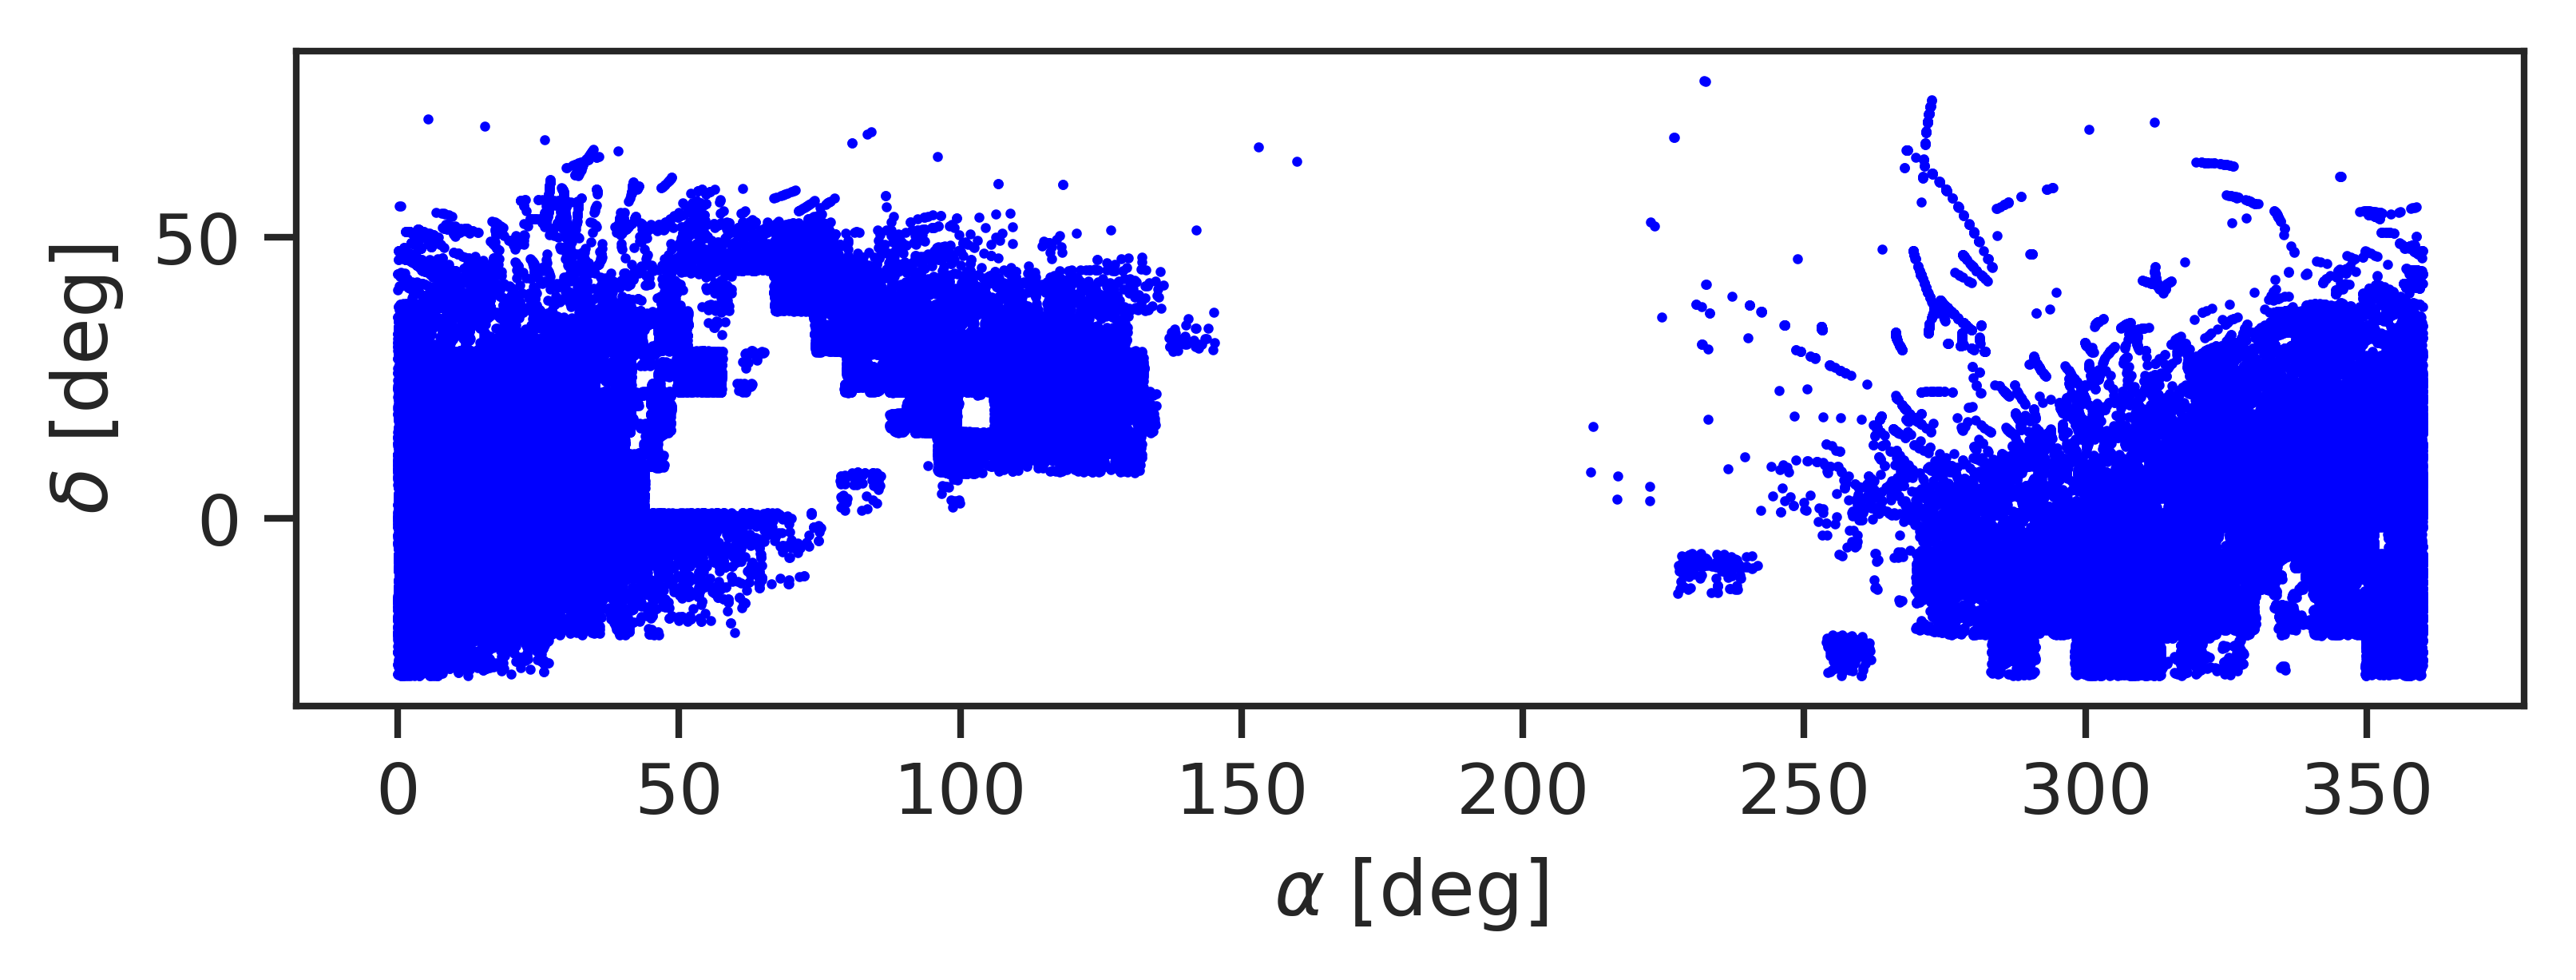

In [62]:
fig, ax = thor.plotObservations(observations, columnMapping=columnMapping, usePlotly=False)

In [42]:
! oorb --task=propagation --orb-in=../analysis/ztf/MPCORB_20181106.orb --epoch-mjd-utc=58364.13048609997 --orb-out=../analysis/ztf/MPCORB_20181106_ZTF.orb --conf=/epyc/opt/oorb/main/oorb.conf 

In [63]:
# We also want keplerian elements
! oorb --task=propagation --orb-in=../analysis/ztf/MPCORB_20181106.orb --epoch-mjd-utc=58364.13048609997 --orb-out=../analysis/ztf/MPCORB_20181106_ZTF_keplerian.orb --conf=../analysis/ztf/oorb.conf 

***ERROR***  9 Nov 2018 19:25:49UTC (Orbit / getKeplerianElements) Orbit is (almost) circular.
   1.5775714866029889E-016
***ERROR***  9 Nov 2018 19:25:49UTC (Orbit / getElements) TRACE BACK
***ERROR***  9 Nov 2018 19:25:49UTC (io / writeOpenOrbOrbitFile) TRACE BACK (5)
***ERROR***  9 Nov 2018 19:25:49UTC (oorb / propagation) Unable to propagate orbit for J97R13L


In [43]:
! oorb --task=ephemeris --code=I41 --orb-in=../analysis/ztf/MPCORB_20181106_ZTF.orb --conf=../analysis/ztf/oorb.conf > ../analysis/ztf/MPCORB_20181106_ZTF.eph

In [45]:
simulated = thor.readEPHFile("../analysis/ztf/MPCORB_20181106_ZTF.eph")

In [50]:
simulated[simulated["designation"].isin(observations["designation"].unique())].to_csv("../analysis/ztf/known_object_observations_nid_610_624.eph", sep=" ", index=False)

In [65]:
orbits = thor.readORBFile("../analysis/ztf/MPCORB_20181106_ZTF_keplerian.orb")

In [66]:
orbits[orbits["designation"].isin(observations["designation"].unique())].to_csv("../analysis/ztf/known_object_observations_nid_610_624.orb", sep=" ", index=False)

In [72]:
# Read alerts for solar system objects from after the photometry fix 
sso_alert_fix_date1 = Time('2018-05-16T23:30:00', format='isot', scale='utc') # first attribution fix
sso_alert_fix_date2 = Time('2018-06-08T23:30:00', format='isot', scale='utc') # second attribution fix
sso_alert_phot_fix_date = Time('2018-06-18T23:30:00', format='isot', scale='utc') # photometry fix date

jd_good = sso_alert_phot_fix_date.jd
#ssdistnr >= 0 
df = pd.read_sql_query('select * from alerts where jd > {} and nid >= 610 and nid <= 624'.format(jd_good), con)
print(len(df))

4966353


In [73]:
df.sort_values(by=["jd"], inplace=True)
df.reset_index(inplace=True)

In [74]:
df.head(10)

,index,objectId,jd,fid,pid,diffmaglim,programid,candid,isdiffpos,tblid,...,clrcounc,zpclrcov,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime
0,88437,ZTF18abdsqbl,2.458365e+06,2,610130484415,19.2443,1,610130484415010015,f,15,...,0.000005,-0.000004,26.328,0.916,0.197519,0.261128,0.261128,12.4554,12.4554,None
1,91863,ZTF18abdysxo,2.458365e+06,2,610130481215,19.1212,1,610130481215010012,f,12,...,0.000027,-0.000018,26.184,0.647,0.149188,0.461806,0.461806,12.8894,12.8894,None
2,91864,ZTF18abdytdq,2.458365e+06,2,610130481215,19.1212,1,610130481215010007,f,7,...,0.000027,-0.000018,26.184,0.647,0.149188,2.922640,21.994800,17.8857,13.5448,None
3,91865,ZTF18abslvpe,2.458365e+06,2,610130481215,19.1212,1,610130481215015021,t,21,...,0.000027,-0.000018,26.184,0.647,0.149188,0.208710,50.003000,15.6539,12.0464,None
4,91866,ZTF18ablqnbj,2.458365e+06,2,610130483515,19.3369,1,610130483515015051,t,51,...,0.000014,-0.000019,26.338,1.375,0.253690,9.445520,35.285700,19.1802,13.5749,None
5,91867,ZTF18abnhsiu,2.458365e+06,2,610130483515,19.3369,1,610130483515010018,f,18,...,0.000014,-0.000019,26.338,1.375,0.253690,4.518850,-999.000000,18.6073,-999.0000,None
6,91868,ZTF18abndtqt,2.458365e+06,2,610130483515,19.3369,1,610130483515010016,f,16,...,0.000014,-0.000019,26.338,1.375,0.253690,5.396270,54.464400,20.0860,13.4593,None
7,91869,ZTF18abnhjji,2.458365e+06,2,610130483515,19.3369,1,610130483515015057,t,57,...,0.000014,-0.000019,26.338,1.375,0.253690,0.368035,-999.000000,14.0504,-999.0000,None
8,91870,ZTF18ablqnba,2.458365e+06,2,610130483515,19.3369,1,610130483515015056,t,56,...,0.000014,-0.000019,26.338,1.375,0.253690,3.422410,79.013800,19.4796,13.9131,None
9,91871,ZTF18abslvpy,2.458365e+06,2,610130483515,19.3369,1,610130483515015069,t,69,...,0.000014,-0.000019,26.338,1.375,0.253690,3.191420,13.708500,18.4593,13.1039,None


In [85]:
observations = prepareZTFAlertsForTHOR(df)
del df

In [86]:
observations.to_csv("../analysis/ztf/observations_nid_610_624.txt", sep=" ", index=False)

In [87]:
# Unique solar system objects in ZTF alerts
observations["ssnamenr"].nunique()

64944

In [88]:
# Multiple formats for ssnamenr field in alerts db
np.random.choice(observations[observations["ssnamenr"].str.isnumeric()]["ssnamenr"].values, 20)

array(['113706', '44222', '463424', '265734', '93026', '36501', '89492',
       '87450', '350949', '58405', '115322', '197220', '142510', '411428',
       '57520', '286019', '419814', '33244', '164979', '72677'],
      dtype=object)

In [89]:
np.random.choice(observations[~observations["ssnamenr"].str.isnumeric()]["ssnamenr"].values, 20)

array(['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', ''], dtype=object)

In [90]:
mpcorb = thor.readMPCORBFile("../analysis/ztf/MPCORB_20181106.DAT")
# Drop two NaN rows... (population split)
mpcorb.drop(index=mpcorb[mpcorb["designation"].isna()].index, inplace=True)

In [91]:
np.random.choice(mpcorb[mpcorb["designation"].str.isnumeric()]["designation"].values, 20)

array(['30311', '33127', '53019', '94354', '97207', '50729', '93658',
       '75037', '92117', '74993', '57847', '80042', '35438', '26381',
       '28486', '70584', '57673', '62581', '79041', '96574'], dtype=object)

In [92]:
np.random.choice(mpcorb[~mpcorb["designation"].str.isnumeric()]["designation"].values, 20)

array(['m9480', 'S7372', 'R2623', 'e2544', 'K14ON2R', 'R6605', 'K06B69M',
       'H1314', 'h5975', 'K11U88A', 'K12D37M', 'K15L33A', 'K16T80G',
       'a1184', 'Z4023', 'K13Q51V', 'K18S14R', 'p8772', 'K15FY9X',
       'F3936'], dtype=object)

In [93]:
mpcorb[mpcorb["readableDesignation"].str.isnumeric()]["readableDesignation"].values

array([], dtype=object)

In [94]:
np.random.choice(mpcorb[~mpcorb["readableDesignation"].str.isnumeric()]["readableDesignation"].values, 20)

array(['2010 GB72', '2013 WE68', '2012 TX222', '(219638) 2001 UB65',
       '2013 AW151', '(348421) 2005 NB65', '(437534) 2013 YM115',
       '(8679) Tingstade', '(266789) 2009 SC268', '(95171) 2002 AT188',
       '(455317) 2002 HA13', '(334212) 2001 SF319', '(514356) 2016 QB9',
       '(501619) 2014 SQ96', '(493687) 2015 SD17', '(436583) 2011 HW100',
       '2013 AX150', '(389131) 2009 AW1', '(279273) 2009 WF1',
       '2015 UQ15'], dtype=object)

In [95]:
# Do pandas magic... 
split_readable_designation = mpcorb["readableDesignation"].str.split(" ", expand=True)
mpcorb.loc[split_readable_designation[0].str.contains("\("), "splitname"] = split_readable_designation[0]
mpcorb.loc[~mpcorb["splitname"].isna(), "splitname"] = mpcorb[~mpcorb["splitname"].isna()]["splitname"].map(lambda x: x.lstrip('\(').rstrip('\)'))
mpcorb.loc[(~mpcorb["readableDesignation"].str.contains("\(")) 
           & (mpcorb["readableDesignation"].str.contains(" ")), "splitname"] = mpcorb[(~mpcorb["readableDesignation"].str.contains("\(")) 
                                                                                      & (mpcorb["readableDesignation"].str.contains(" "))]["readableDesignation"].str.replace(" ", "")

In [101]:
observations = observations.merge(mpcorb[["designation", "splitname"]], left_on="ssnamenr", right_on="splitname", how='left')

In [102]:
observations["ssnamenr"].nunique()

64944

In [103]:
observations["designation"].nunique()

64313

In [105]:
observations.to_csv("../analysis/ztf/observations_nid_610_624.txt", sep=" ", index=False)